# An integrated diagnostic analysis of plasma waves

## Setup
Identify time ranges into which to separate the analysis. Locate crash times and define several time slices containing different waves. Display several illustrative graphs.


Import necessary packages

In [1]:
from lib.imports_BES import *
from lib.analysis_functions_BES import *
from lib.analysis_functions_Mirnov import *
from lib.analysis_functions_general import *

Load BES data from various NETCDF files

In [2]:
# Specify path to where data is stored
bes_data_path = "BES_code_local/Data/"
shot = 29378
shotlabel = "\#" + str(shot)

# Dalpha data. Array for time and array for values
dalpha_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_dalpha.nc")
dalpha_time = np.asarray(dalpha_from_file.coords['time'])
dalpha_data = np.asarray(dalpha_from_file)

# Upper tangential Dalpha. Array for time and array for values
utda_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_upper_tan_dalpha.nc")
utda_time = np.asarray(utda_from_file.coords['time'])
utda_data = np.asarray(utda_from_file)

# Line-averaged density. Array for time and array for values
density_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_density.nc")
density_time = np.asarray(density_from_file.coords['time'])
density_data = np.asarray(density_from_file)

# Equilibria from EFIT. Two spacial arrays, a time array and 2D array of psi
equilib_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_equilibria.nc")
equilib_time = np.asarray(equilib_from_file.coords['time'])
equilib_R = np.asarray(equilib_from_file.coords['R'])
equilib_Z = np.asarray(equilib_from_file.coords['Z'])
equilib_psi = np.asarray(equilib_from_file)

# (R, z) locations for the BES channels. Shape: (32,2)
apdpos = np.asarray(xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_apdpos.nc"))

# Main BES data. Array for times and shape (32,time) array for fluctuation
fluct_data_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_LH_fluct_data.nc")
bes_time = np.asarray(fluct_data_from_file.coords['time'])
fluct_data = np.asarray(fluct_data_from_file)
f_samp_BES = 1/np.mean(np.diff(bes_time))

Load Mirnov coil data

In [3]:
mirnov_data_path = "Mirnov_code_local/Data/"

# Get coil positions
coilpos = np.asarray(xr.open_dataarray(mirnov_data_path + "coil_positions.nc"))

# Main Mirnov data
mirnov_data_from_file = xr.open_dataarray(mirnov_data_path + "shot" + str(shot) + "_mirnov_data.nc")
mirnov_time = np.asarray(mirnov_data_from_file.coords['time'])
coil_nums = np.asarray(mirnov_data_from_file.coords['coil']) # Coil numbers e.g. 210 for coils in order of data
mirnov_data = np.asarray(mirnov_data_from_file) # Shape (11,650000)
f_samp_mirnov = 1/np.mean(np.diff(mirnov_time))
# Useful coils appear to be [206, 207, 210, 212, 213, 214]
coil_nums = coil_nums[1:7]
mirnov_data = mirnov_data[1:7]
coilpos = coilpos[1:7]

Plot $D_\alpha$ data to identify times of interest then input ranges to separate analysis into. Change these as needed

In [4]:
# Change regions' bounds as needed
regions = [[0.16,0.24], [0.36,0.54], [0.54,0.68]]

# BES time is limited to ~0.65
for i in range(len(regions)):
    if regions[i][1] > bes_time[-1]:
        print("Region", i, "trimmed", str(regions[i]), "to", np.around([regions[i][0], bes_time[-1]],2))
        regions[i] = [regions[i][0], bes_time[-1]]

Region 2 trimmed [0.54, 0.68] to [0.54 0.65]


Plot regions so time ranges can be fine-tuned.

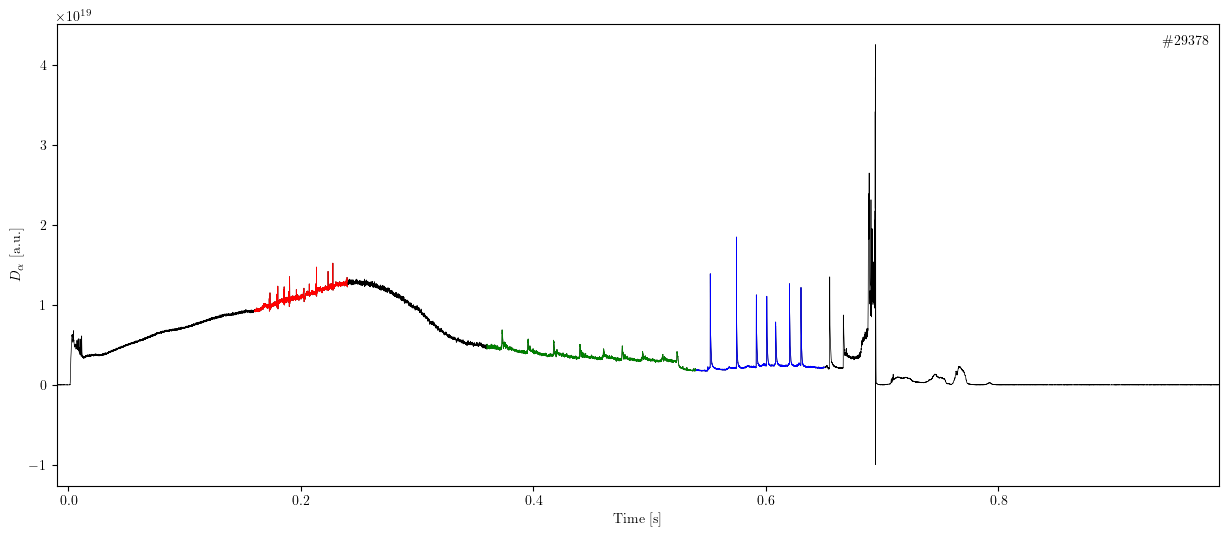

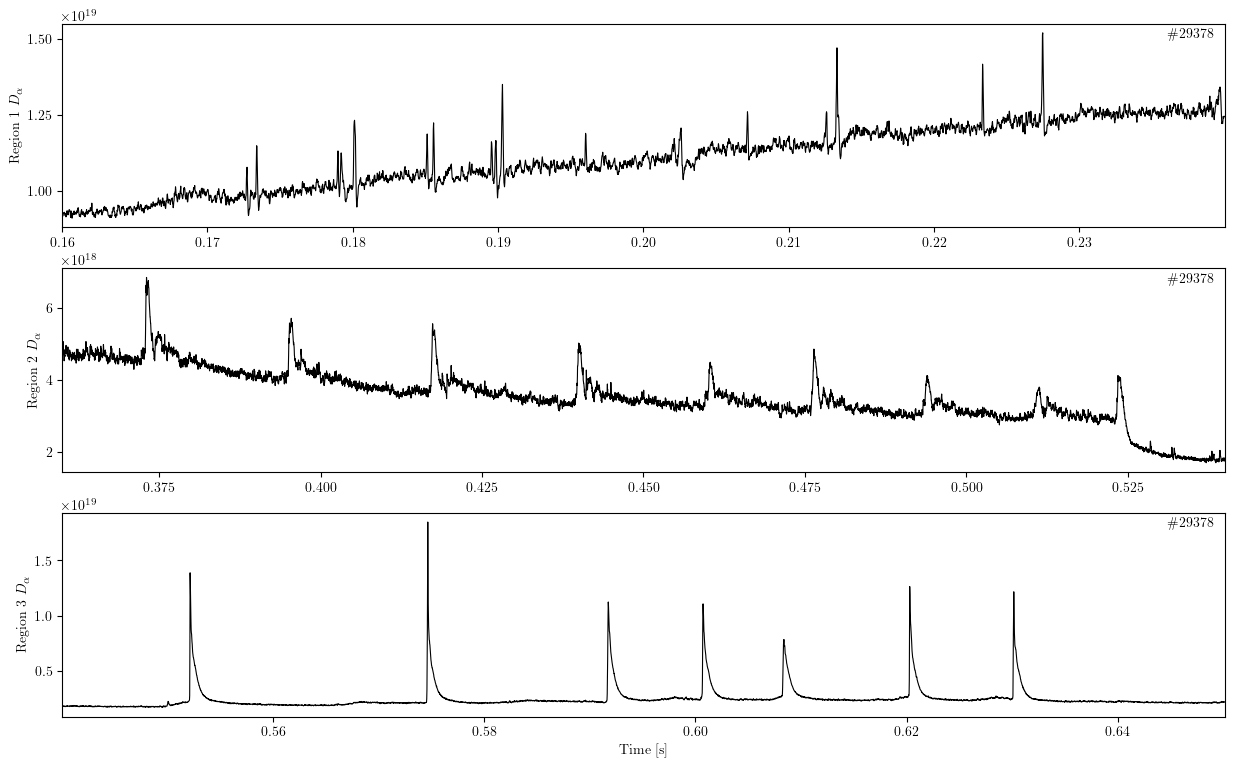

In [5]:
colours = ["r", "g", "b", "c", "m", "y"] # Each region plotted in different colour

# Big plot of Dalpha with regions differently colours
fig1, ax1 = plt.subplots(1, 1, figsize=(15, 6))
ax1.plot(dalpha_time, dalpha_data, 'k', linewidth=0.5)

# Plots of each region separately
fig2, ax2 = plt.subplots(len(regions), 1, sharex=False, figsize=(15, 9))

for i in range(len(regions)):
    idx1 = (np.abs(dalpha_time - regions[i][0])).argmin()
    idx2 = (np.abs(dalpha_time - regions[i][1])).argmin()
    ax1.plot(dalpha_time[idx1:idx2+1], dalpha_data[idx1:idx2+1], colours[i], linewidth=0.5)
    
    ax2[i].plot(dalpha_time[idx1:idx2], dalpha_data[idx1:idx2], 'k', linewidth=0.8)
    ax2[i].tick_params(axis='x')
    ax2[i].tick_params(axis='y')
    ax2[i].set_ylabel(r"Region " + str(i+1) + r" $D_\alpha$")
    ax2[i].locator_params(axis='y', nbins=3)
    ax2[i].set_xlim([dalpha_time[idx1], dalpha_time[idx2]])
    ax2[i].text(.99, .975, shotlabel, ha='right', va='top', transform=ax2[i].transAxes)

ax1.set_xlabel("Time [s]")
ax1.set_ylabel(r"$D_\alpha$ [a.u.]")
ax1.set_xlim([dalpha_time[0], dalpha_time[-1]])
ax1.text(.99, .975, shotlabel, ha='right', va='top', transform=ax1.transAxes)

ax2[-1].set_xlabel("Time [s]")

#fig1.savefig("Full_Dalpha_plot.pdf", format="pdf", bbox_inches="tight")
#fig2.savefig("Dalpha_region_plots.pdf", format="pdf", bbox_inches="tight")

plt.show()
plt.close()

Now use tangential $D_\alpha$ data to identify crash times. Set threshold for each region so that the blue line runs below most of the peaks while avoiding baseline noise.

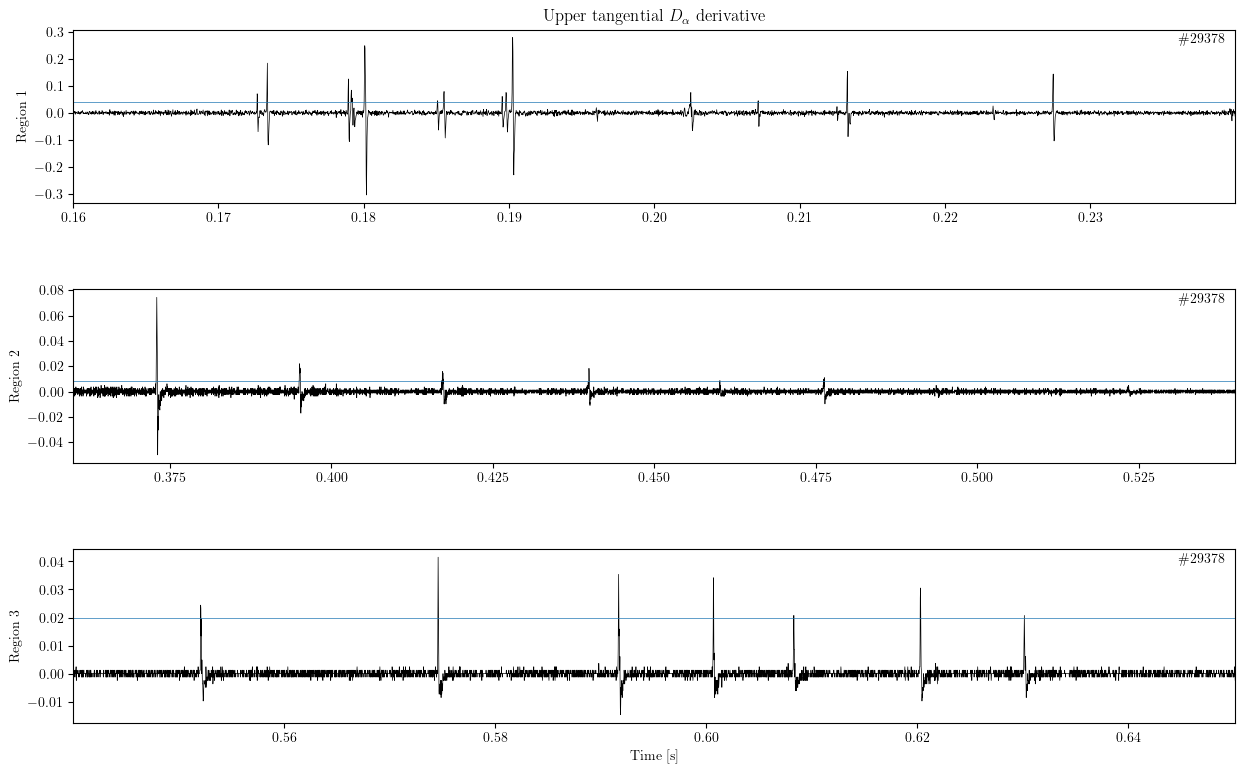

In [6]:
thresholds = [0.04, 0.008, 0.02]
figure, axes = plt.subplots(len(regions), 1, sharex=False, figsize=(15, 9))

for i in range(len(regions)):
    idx1 = (np.abs(utda_time - regions[i][0])).argmin()
    idx2 = (np.abs(utda_time - regions[i][1])).argmin()
    
    axes[i].plot(utda_time[idx1:idx2], np.gradient(utda_data[idx1:idx2]), "k", linewidth=0.5)
    axes[i].hlines(thresholds[i], utda_time[idx1], utda_time[idx2], linewidth=0.5)
    axes[i].set_ylabel("Region " + str(i+1))
    axes[i].locator_params(axis="y", nbins=7)
    axes[i].text(.99, .975, shotlabel, ha='right', va='top', transform=axes[i].transAxes)
    axes[i].set_xlim([utda_time[idx1], utda_time[idx2]])

axes[-1].set_xlabel("Time [s]")
axes[0].set_title(r"Upper tangential $D_\alpha$ derivative")
plt.subplots_adjust(hspace=0.5)

plt.show()
plt.close()

Using thresholds defined above, find windows around crashes

Change start/end shifts as needed

In [7]:
pre_crash_windows = {}
post_crash_windows = {}
crash_times = {}

crash_times[0] = get_crash_times(utda_time, utda_data, thresholds[0], regions[0])
pre_crash_windows[0] = get_crash_adjacent_window(utda_time, utda_data, thresholds[0], regions[0], start_shift=2e-3, end_shift=0.5e-3)
post_crash_windows[0] = get_crash_adjacent_window(utda_time, utda_data, thresholds[0], regions[0], start_shift=-0.5e-3, end_shift=-3e-3)

for region in range(1,len(regions)):
    crash_times[region] = get_crash_times(utda_time, utda_data, thresholds[region], regions[region])
    pre_crash_windows[region] = get_crash_adjacent_window(utda_time, utda_data, thresholds[region], regions[region], start_shift=4e-3, end_shift=0.75e-3)
    post_crash_windows[region] = get_crash_adjacent_window(utda_time, utda_data, thresholds[region], regions[region], start_shift=-1e-3, end_shift=-5e-3)

Make some plots to check that windows found are sensible, readjust above as needed

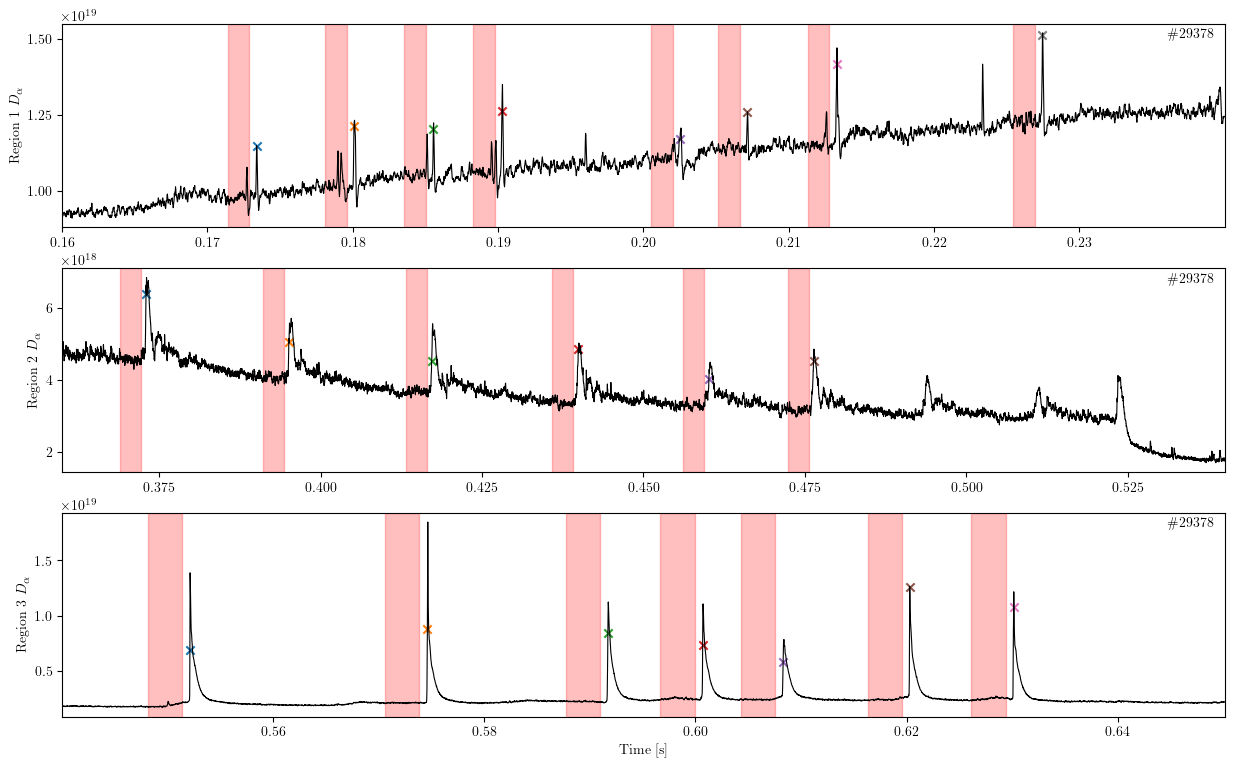

In [8]:
# Plots of each region separately with found crashes marked
fig, ax = plt.subplots(len(regions), 1, sharex=False, figsize=(15, 3*len(regions)))

for i in range(len(regions)):
    idx1 = (np.abs(dalpha_time - regions[i][0])).argmin()
    idx2 = (np.abs(dalpha_time - regions[i][1])).argmin()
    
    ax[i].plot(dalpha_time[idx1:idx2], dalpha_data[idx1:idx2], 'k', linewidth=0.8)
    ax[i].text(.99, .975, shotlabel, ha='right', va='top', transform=ax[i].transAxes)
    for peak in crash_times[i]:
        crash_amplitude = dalpha_data[(np.abs(dalpha_time - peak)).argmin()]
        ax[i].scatter(peak, crash_amplitude, marker="x")
        
    for pre_window in pre_crash_windows[i]:
        #ax[i].vlines(pre_window[0], np.min(dalpha_data[idx1:idx2]), np.max(dalpha_data[idx1:idx2]), "g", linestyle="dashed", linewidth=0.5)
        #ax[i].vlines(pre_window[1], np.min(dalpha_data[idx1:idx2]), np.max(dalpha_data[idx1:idx2]), "r", linestyle="dashed", linewidth=0.5)
        ax[i].axvspan(pre_window[0], pre_window[1], alpha=0.25, color='red')

    #for post_window in post_crash_windows[i]:
        #ax[i].vlines(post_window[0], np.min(dalpha_data[idx1:idx2]), np.max(dalpha_data[idx1:idx2]), "m", linestyle="dotted", linewidth=0.5)
        #ax[i].vlines(post_window[1], np.min(dalpha_data[idx1:idx2]), np.max(dalpha_data[idx1:idx2]), "c", linestyle="dotted", linewidth=0.5)
    #    ax[i].axvspan(post_window[0], post_window[1], alpha=0.25, color='cyan')
    
    ax[i].tick_params(axis='x')
    ax[i].tick_params(axis='y')
    ax[i].set_ylabel(r"Region " + str(i+1) + r" $D_\alpha$")
    ax[i].locator_params(axis='y', nbins=3)
    ax[i].set_xlim([dalpha_time[idx1], dalpha_time[idx2]])
    ax[i].text(.99, .975, shotlabel, ha='right', va='top', transform=ax2[i].transAxes)

ax[-1].set_xlabel("Time [s]")
plt.show()
plt.close()

Show windows on spectrograms. Only one column plotted as they aren't significantly different - crashes appear at pretty much the same time in all columns.

In [9]:
if False:
    # Show pre-crash windows first
    for i in range(len(regions)):
        sum_bes_fluct_spectrogram(shot, bes_time, fluct_data, 0, regions[i], vlines=pre_crash_windows[i], plot=True)

    # Then show post-crash windows
    for i in range(len(regions)):
        sum_bes_fluct_spectrogram(shot, bes_time, fluct_data, 0, regions[i], vlines=post_crash_windows[i], plot=True)

Once happy, calculate average distance of each column from separatrix over a given timeslice

In [10]:
if False:
    with open("dist_in_sol.csv", "w") as f:
        f.write("Region")
        for i in range(8):
            f.write(",Col " + str(i+1))
        f.write("\n")

        for region in range(len(regions)):
            f.write(str(region+1))
            for col in range(8):
                f.write("," + str(sol_dist(equilib_time, equilib_R, equilib_Z, equilib_psi, apdpos, regions[region], col)))
            f.write("\n")
            
dists_in_sol = pd.read_csv("BES_code_local/Data/dist_in_sol.csv", index_col=0)

# Analysis

By this point you should be happy with the regions and the pre- and post-crash windows.

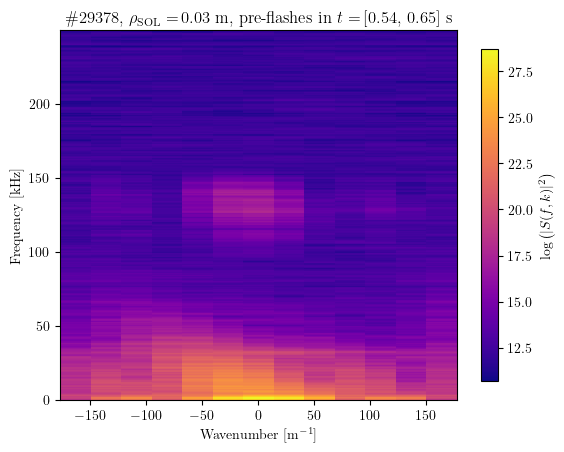

In [11]:
# 1: 1, 4
# 2: 3, 6
# 3: 4, 7

region = 2
col = 7

sol_dist = np.round(dists_in_sol.loc[region+1].at["Col " + str(col)],2)
plot_title = "\#" + str(shot) + r", $\rho_{\rm SOL}=\,$" + str(sol_dist) + " m, pre-flashes in $t =\,$" + str(list(np.round(regions[region],2))) + " s"
fn = "kf_pre_reg_" + str(region+1) + "_col_" + str(col+1)
xlabel = "Wavenumber [m$^{-1}$]"
f_arr, k_arr, kf_matrix = kf_spec_sum_windows(bes_time, fluct_data, apdpos, col, pre_crash_windows[region])
plot_dispersion_relation(f_arr, k_arr, kf_matrix, plot_title, xlabel, fmin=0.0e3, fmax=250.0e3, smooth_pts=5, conditional=False, save=False)

Define timeslices that contain interesting features

In [12]:
chirps_down = [[0.384,0.3895], [0.411, 0.416], [0.427, 0.433], [0.449, 0.455]]
chirps_down_franges_mirnov = [ # Optimised for coil idx=2, plot profile non-log
    [[7000, 12000], [15000, 23000]],
    [[6000, 10000], [17000, 25000]],
    [[7000, 11000], [14000, 19500]],
    [[6000, 11000], [14500, 18500]]
]


elm_125 = [[0.5653,0.5665], [0.5816,0.5828], [0.595,0.596], [0.606,0.607], [0.618,0.619], [0.6267,0.628]]
elm_125_franges_bes = [ # Optimised for col idx=6, plot profile non-log
    [97500, 150000],
    [100000, 145000],
    [90000, 140000],
    [95000, 145000],
    [90000, 135000],
    [101000, 135000]
]

centres = [0.559, 0.6127, 0.624, 0.6335, 0.644]
elm_harmonics = [[i-0.0025, i+0.0025] for i in centres]
elm_harmo_franges_mirnov = [ # Optimised for coil idx=2
    [[8950, 13100], [18000, 25500], [29500,37500]],
    [[8000, 15000], [20050, 27150], [32000,39900]],
    [[10500, 16000], [22500, 29000], [36500,41500]],
    [[8000, 15000], [21500, 30000], [37500,43000]],
    [[7000, 14500], [18500, 25500], [29500,37500]]
]

elm_pcw = []
for i in range(len(elm_125)):
    elm_pcw.append(np.array([elm_125[i][1], crash_times[2][1:][i]-0.0005]))

Plot BES and Mirnov spectrograms showing these timeslices

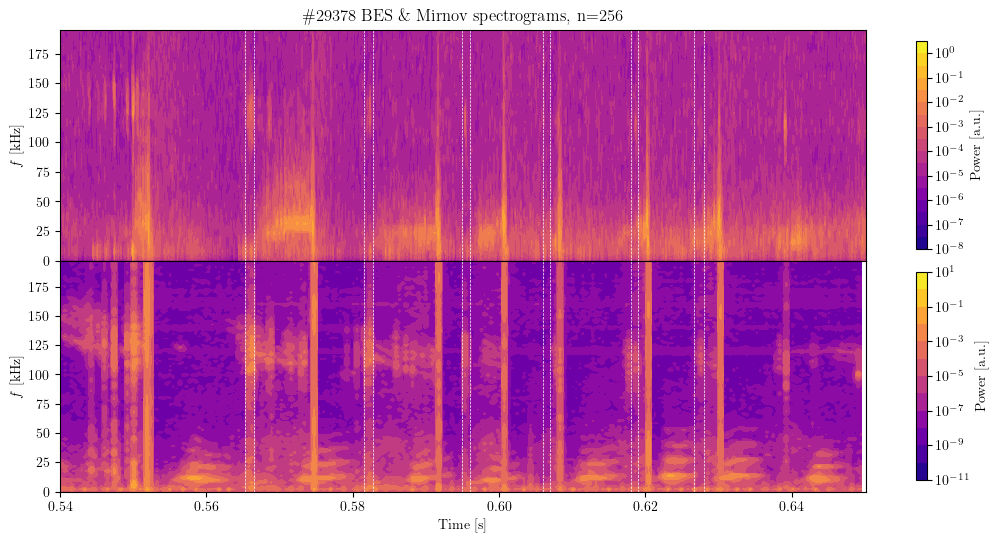

In [13]:
region = 2
windows = elm_125

fig, ax = plt.subplots(2,1, sharex=True, figsize=(13,6))

freq1, times1, Sxx1 = sum_bes_fluct_spectrogram(shot, bes_time, fluct_data, 4, regions[region], n=8, plot=False)
f200_1 = (np.abs(freq1 - 200e3)).argmin()
freq2, times2, Sxx2 = sum_mirnov_fluct_spectrogram(shot, mirnov_time, mirnov_data, regions[region], n=8, plot=False)
f200_2 = (np.abs(freq2 - 200e3)).argmin()

cb1 = ax[0].contourf(times1,1e-3*freq1[:f200_1],Sxx1[:f200_1,:], 16, cmap=plt.get_cmap('plasma'), levels=[10**(i/10) for i in range(-80,10,5)],
                norm=(colors.LogNorm()))
ax[0].set_ylabel(r"$f$ [kHz]")
cb2 = ax[1].contourf(times2,1e-3*freq2[:f200_2],Sxx2[:f200_2,:], 16, cmap=plt.get_cmap('plasma'), levels=[10**i for i in range(-11,2)],
                norm=(colors.LogNorm()))
ax[1].set_ylabel(r"$f$ [kHz]")


fig.colorbar(cb1, shrink=0.9, label="Power [a.u.]", format=ticker.FuncFormatter(fmt))
fig.colorbar(cb2, shrink=0.9, label="Power [a.u.]", format=ticker.FuncFormatter(fmt))

for axis in range(2):
    for i in range(len(windows)):
        ax[axis].vlines(windows[i][0], ax[axis].get_ylim()[0], ax[axis].get_ylim()[1], "w", ls='--', linewidth=0.5)
        ax[axis].vlines(windows[i][1], ax[axis].get_ylim()[0], ax[axis].get_ylim()[1], "w", ls='--', linewidth=0.5)

idx1 = (np.abs(dalpha_time - regions[region][0])).argmin()
idx2 = (np.abs(dalpha_time - regions[region][1])).argmin()

plt.xlim(left=regions[region][0], right=regions[region][1])
ax[0].set_title("\#" + str(shot) + " BES \& Mirnov spectrograms, n=" + 
            str(int(2**8)))
ax[1].set_xlabel("Time [s]")
fig.subplots_adjust(hspace=0)

#plt.savefig("elm_125_col5.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [14]:
freq_ranges = np.asarray([
    [[10.0, 12.5], [19.8, 21.5], [30.2, 31.7]],
    [[11.0, 12.5], [24.0, 26.0], [36.2, 38.0]],
    [[12.3, 13.5], [25.0, 27.0], [39.0, 40.6]],
    [[11.0, 13.2], [23.0, 25.2], [29.0, 35.0]],
    [[10.0, 12.0], [20.0, 22.0], [31.2, 32.5]],
])*1.0e3

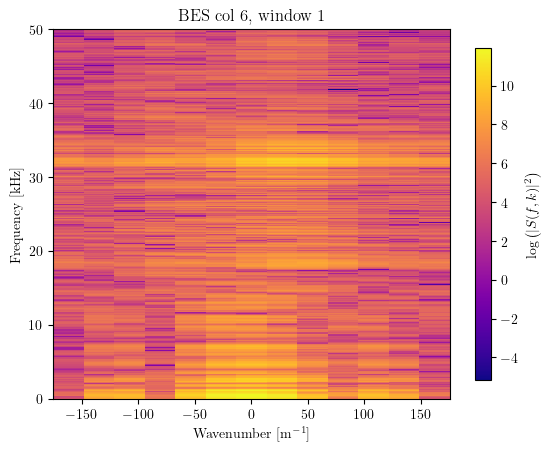

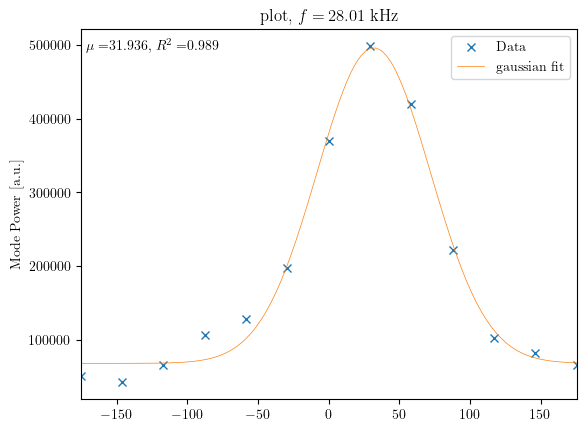

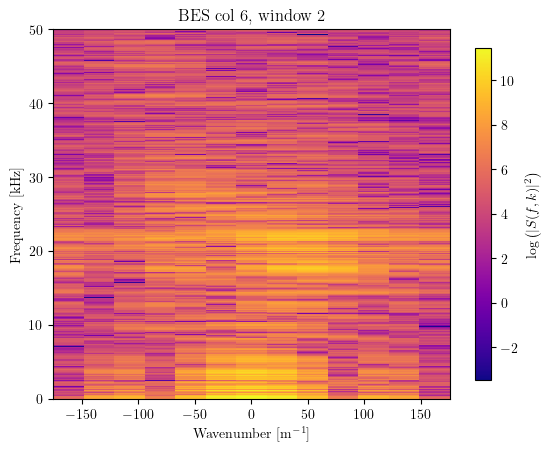

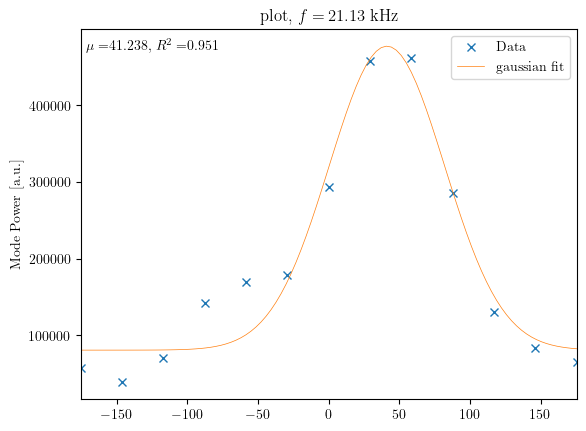

In [15]:
ms = []
merr = []
fs = []

elm_pcw_franges = [
    [31500,32800], [21500,23000]
]
for window in range(2):
    f_arr, k_arr, kf_matrix = get_kf_spec(bes_time, fluct_data, apdpos, 6, elm_pcw[window])
    plot_dispersion_relation(f_arr, k_arr, kf_matrix, "BES col 6, window " + str(window+1), r"Wavenumber [$\mathrm{m^{-1}}$]", fmin=0e3, fmax=50e3, smooth_pts=5)
    get_k_profile(f_arr, k_arr, kf_matrix, [10e3,40e3], fit=gaussian, plot="plot")
    
    """centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, elm_harmonics[window])
    coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))
    f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, elm_harmonics[window])
    plot_dispersion_relation(f_arr, k_arr, kf_matrix, "\#29378 Mirnov data, harmonic window " + str(window+1), "Poloidal mode number", fmin=0e3, fmax=50e3, smooth_pts=5, save=False)"""
    """tmp = []
    err_tmp = []
    f_tmp = []
    for mode in range(1):
        _,_, mu, err, fpeak = get_k_profile(f_arr, k_arr, kf_matrix, elm_125_franges_bes[window], fit=gaussian, plot="\#29378")
        tmp.append(mu)
        err_tmp.append(err)
        f_tmp.append(fpeak)
    ms.append(tmp)
    merr.append(err_tmp)
    fs.append(f_tmp)"""

In [16]:
for i in range(len(ms)):
    print(str(i+1), end=" & ")
    for x in range(len(ms[i])):
        print(str(np.round(fs[i][x]*1e-3,1)) + r" &" + " $" + str(np.round(ms[i][x],2)) + "\\pm" + str(np.round(merr[i][x],2)) + "$ & ",  end="")
    print("\\\\")

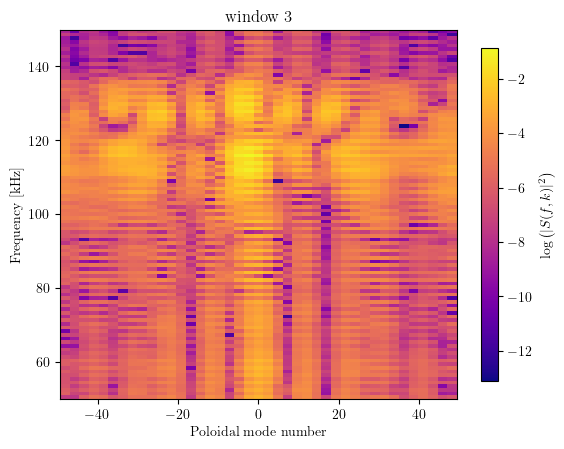

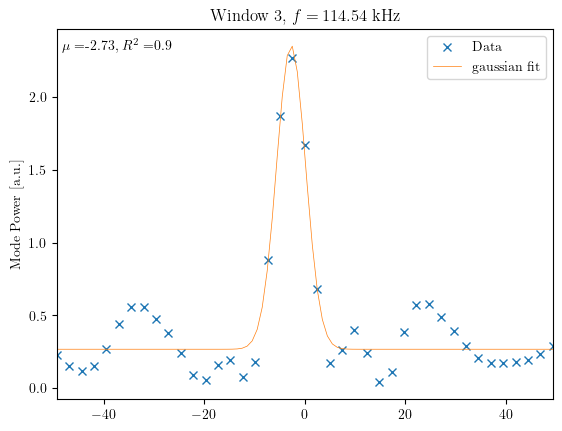

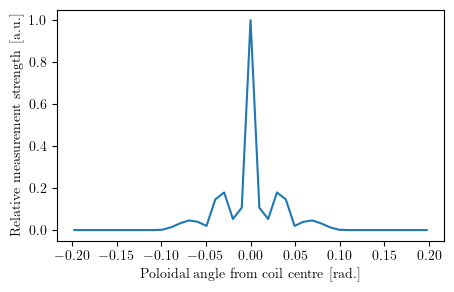

In [17]:
interest = elm_125
elm_125_mranges = [[100000,120000],[110000,120000],[110000,120000],[118000,122000],[100000,115000],[110000,125000]]
chirps_down_mranges = np.asarray([
    [[7.8, 13.5], [16.0, 22.0]],
    [[7.0, 9.0], [18.0, 25.0]],
    [[7.5, 10.0], [14.2, 16.0]],
    [[7.5, 11.0], [15.0, 17.0]],
])*1.0e3
ms = []
merr = []
fs = []
for w in range(2,3):
    centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, interest[w])
    coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))
    f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, interest[w])
    plot_dispersion_relation(f_arr, k_arr, kf_matrix, "window " + str(w+1), "Poloidal mode number", fmin=50e3, fmax=150e3, smooth_pts=5)
    k_arr, profile, mu, err, fpeak = get_k_profile(f_arr, k_arr, kf_matrix, elm_125_mranges[w], fit=gaussian, plot="Window " + str(w+1))
    ms.append(mu)
    merr.append(err)
    fs.append(fpeak*1e-3)
    
    ps = np.fft.ifft(profile)
    spaces = np.fft.fftfreq(k_arr.size, np.mean(np.diff(k_arr)))
    idx = np.argsort(spaces)
    fig, ax = plt.subplots(1,1, figsize=(5,3))
    ax.plot(spaces[idx], np.abs(ps[idx])**2/np.max(np.abs(ps[idx])**2))
    ax.set_ylabel("Relative measurement strength [a.u.]")
    ax.set_xlabel("Poloidal angle from coil centre [rad.]")
    plt.savefig("coil_width_example.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

In [51]:
ms

[1.2659196570912559,
 1.5731724796843947,
 1.9344884928475905,
 0.7240117892020485]

In [52]:
fs

[19.08092660028398, 21.2598934962309, 15.223626716414731, 15.863492470318947]

## Mirnov phases

In [37]:
def get_phase_spectrogram(sig_time, sig_data, f_samp, timeslice, n=8, mode="angle", plot=False):
    idx1 = (np.abs(sig_time-timeslice[0])).argmin()
    idx2 = (np.abs(sig_time-timeslice[1])).argmin()
    freqs, times, Pxx = sig.spectrogram(sig_data[idx1:idx2], fs=f_samp, nperseg=(2 ** n), mode=mode)
    
    if plot != False:
        figure, axes = plt.subplots(1, 1, figsize=(11, 4))
        ct = axes.contourf(times+sig_time[idx1], 1e-3*freqs, Pxx, cmap="plasma")
        cbar = figure.colorbar(ct, shrink=0.9, label="Phase [rad.]")
        axes.set_title(plot)
        axes.set_xlabel("Time [s]")
        axes.set_ylabel("Frequency [kHz]")
        plt.show()
        
    return times+sig_time[idx1], freqs, Pxx

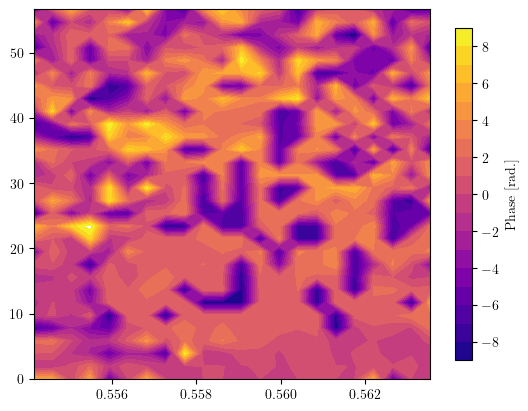

In [116]:
t1, f1, p1 = get_phase_spectrogram(mirnov_time, mirnov_data[0], f_samp_mirnov, regions[2], mode="angle", plot=False)
t6, f6, p6 = get_phase_spectrogram(mirnov_time, mirnov_data[5], f_samp_mirnov, regions[2], mode="angle", plot=False)

pd = (p6-p1)/(2*np.pi)
centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, regions[2])
coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))
scaleup = 2*np.pi/(coilpos_angles[0]-coilpos_angles[5])
out = pd*scaleup

idx1 = (np.abs(t1-elm_harmonics[0][0])).argmin()-5
idx2 = (np.abs(t1-elm_harmonics[0][1])).argmin()+6b

fig, ax = plt.subplots(1,1)
ct = ax.contourf(t1[idx1:idx2],f1[:30]*1e-3,out[:30,idx1:idx2],cmap="plasma",levels=np.arange(-9,10))# extent=[t1[0], t1[-1], f1[0]*1e-3, f1[-1]*1e-3], aspect="auto")
cbar = figure.colorbar(ct, shrink=0.9, label="Phase [rad.]")
plt.show()